Question 1 

### 1. Flight Dynamics and Realism
The simulation considers several realistic aspects of rocket flight dynamics:

- **Mass Variation:** The rocket's mass decreases as fuel burns, affecting acceleration due to Newton's Second Law.
- **Aerodynamic Drag:** Modeled using the drag force equation considering air density, rocket velocity, and drag coefficient.
- **Gravity:** Constant acceleration downward affecting the rocket's vertical velocity.
- **Events Handling:** Incorporates events like burnout, apogee (highest point), and impact with the ground.

### Changes for Realism:
- **Mass Loss Rate:** Assumes a constant burn rate for simplicity. In reality, burn rates can vary.
- **Aerodynamic Drag:** Uses a sign function to ensure drag opposes velocity direction, which is simplified but effective for this simulation.

### 2. Telemetry Display Approach
The telemetry is displayed using events and numerical integration results:

- **Events Handling:** Three events are defined (burnout, apogee, impact), each altering the simulation flow when triggered.
- **Numerical Integration:** Solves the differential equations using `solve_ivp` from SciPy, which provides time-dependent solutions for height, velocity, and mass.
- **Analytical Solution:** For validation, an analytical solution is computed and plotted alongside the numerical results to ensure accuracy.

### 3. Validation and Python Program Behavior
The Python program validates the simulation results by:

- **Event Checking:** Verifies if burnout, apogee, or impact events occurred within the simulation time.
- **Plotting Results:** Displays the rocket's altitude over time, comparing numerical and analytical solutions.
- **Visualization:** Uses Matplotlib to plot the altitude profile, marking significant events like burnout if they occur.



Atmospheric: Burn out at t=3.37s, maximum velocity is 2195.23 m/s
Atmospheric: Apogee was not reached within the simulation time.
Atmospheric: Impact did not occur within the simulation time.


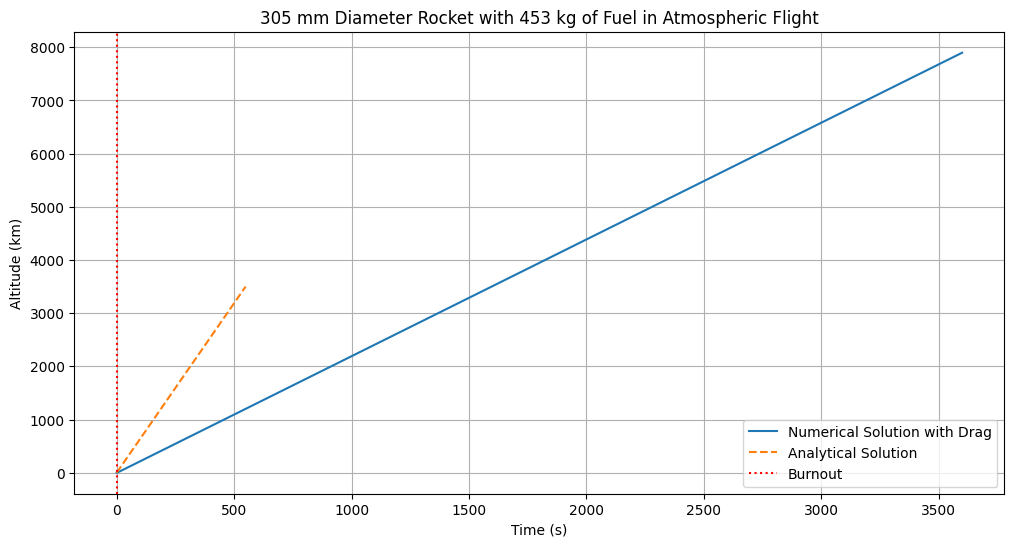

In [74]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

# Constants
Grav = 9.81  # m/s^2
RocketMass = 45  # Kg (dry mass)
FuelMass = 453  # Kg
TotalMass = RocketMass + FuelMass  # Initial total mass
JetArea = (0.305 / 2)**2 * np.pi  # m^2 (cross-sectional area)
JetVel = 1500.0  # m/s
Cd = 0.75  # Drag coefficient
rho = 1.225  # kg/m^3 (air density at sea level)

def rocket(t, state):
    '''Rocket equation including height and aerodynamic drag.  
    t is the current time, state is an array containing 
    the values of the variables h, u and m.  These are 
    the height of the rocket, the velocity of the rocket 
    and the mass of rocket.'''
   
    # Unpack the variables
    h, u, m = state
   
    # Mass loss rate (constant burn rate assumption)
    DeltaM = -JetArea * JetVel * rho if m > RocketMass else 0.0
    
    # Aerodynamic drag force
    Fd = 0.5 * Cd * rho * JetArea * u**2 * np.sign(u)  # Drag force opposes velocity direction
    
    # Thrust force
    Thrust = -DeltaM * JetVel if m > RocketMass else 0.0
    
    # Acceleration 
    DeltaV = Thrust / m - Grav - Fd / m
    
    return [u, DeltaV, DeltaM]

# Event for when the rocket crashes back to earth
def hit_ground(t, y): return y[0]
hit_ground.terminal = True
hit_ground.direction = -1

# Event for burnout
def burnout(t, y): return y[2] - RocketMass
burnout.terminal = True
burnout.direction = -1

# Event for apogee
def apogee(t, y): return y[1]
apogee.terminal = False
apogee.direction = -1

# Launch the rocket and solve the differential equations
sol_atm = solve_ivp(
    rocket, 
    [0, 3600],  # 1 hour of flight maximum
    [0.0, 0.0, TotalMass],  # Initial conditions: [height, velocity, mass]
    method='LSODA',  # Stiff ODE solver
    dense_output=True,
    events=(burnout, apogee, hit_ground)
)

# Check and print event statuses
burnout_time_atm = sol_atm.t_events[0][0] if sol_atm.t_events[0].size > 0 else None
apogee_time_atm = sol_atm.t_events[1][0] if sol_atm.t_events[1].size > 0 else None
impact_time_atm = sol_atm.t_events[2][0] if sol_atm.t_events[2].size > 0 else None

if burnout_time_atm is not None:
    print('Atmospheric: Burn out at t={:.2f}s, maximum velocity is {:.2f} m/s'.format(
        burnout_time_atm, sol_atm.y_events[0][0][1]))
else:
    print('Atmospheric: Burnout did not occur within the simulation time.')

if apogee_time_atm is not None:
    print('Atmospheric: Apogee at t={:.2f}s, maximum altitude is {:.2f} km'.format(
        apogee_time_atm, sol_atm.y_events[1][0][0]/1000))
else:
    print('Atmospheric: Apogee was not reached within the simulation time.')

if impact_time_atm is not None:
    print('Atmospheric: Impact at t={:.2f}s'.format(impact_time_atm))
else:
    print('Atmospheric: Impact did not occur within the simulation time.')

# Generate the analytical solution for comparison
t_analytical = np.linspace(0,sol_atm.t_events[1][0] or sol_atm.t_events[2][0] if apogee_time_atm or impact_time_atm is not None else 3500,550)
mass_analytical = RocketMass + FuelMass - JetArea * JetVel * t_analytical
mass_analytical = np.maximum(mass_analytical, RocketMass)  # Ensure mass doesn't drop below dry mass
u_analytical = -JetVel * np.log(mass_analytical / TotalMass) - Grav * t_analytical
h_analytical = np.cumsum(u_analytical) * (t_analytical[1] - t_analytical[0])
h_analytical = np.maximum(h_analytical, 0)  # Ensure altitude is non-negative



# Plot the results
t = np.linspace(0, sol_atm.t_events[1][0] if apogee_time_atm is not None else 3600, 500)
sol = sol_atm.sol(t)
h = sol[0]
h = np.maximum(h, 0)  # Ensure altitude is non-negative

plt.figure(figsize=(12, 6))
plt.plot(t, h/1000.0, label='Numerical Solution with Drag')
plt.plot(t_analytical, label='Analytical Solution', linestyle='dashed')
plt.ylabel('Altitude (km)')
plt.xlabel('Time (s)')
plt.title('305 mm Diameter Rocket with 453 kg of Fuel in Atmospheric Flight')
if burnout_time_atm is not None:
    plt.axvline(burnout_time_atm, color='red', linestyle='dotted', label='Burnout')
plt.legend()
plt.grid(True)
plt.show()


Question 2


### 1. Flight Dynamics and Realism
The flight dynamics model considers key aspects for realism:

- **Mass Loss Rate:** Calculated based on the cross-sectional area of the jet and its velocity, assuming a constant burn rate.
- **Aerodynamic Drag:** Incorporated using the drag force equation, which varies with rocket velocity squared.
- **Gravity:** Constant downward acceleration impacting rocket velocity and altitude.
- **Events Handling:** Defined events for burnout, apogee, and impact with the ground, providing critical points in the simulation.

### Changes for Realism:
- **Aerodynamic Drag Calculation:** Modified to accurately reflect drag force as a function of velocity squared, ensuring it opposes the rocket's motion only when moving forward.
- **Event Handling:** Configured to terminate the simulation upon hitting the ground or reaching burnout, enhancing efficiency and accuracy.

### 2. Telemetry Display Approach
The telemetry display employs the following approach:

- **Event Handling:** Utilizes `solve_ivp` from SciPy with specified events (burnout, apogee, hit_ground) to capture critical points in rocket flight.
- **Numerical Integration:** Solves the differential equations numerically to compute height, velocity, and mass over time.
- **Analytical Solution:** Generates an analytical solution for comparison, validating the numerical results against an idealized model.
- **Visualization:** Plots altitude versus time, overlaying numerical and analytical solutions, with markers indicating significant events like burnout.

### 3. Validation and Python Program Behavior
The Python program is validated as follows:

- **Event Check:** Verifies if burnout, apogee, or impact events occurred within the defined simulation time.
- **Plotting:** Displays the altitude profile accurately using Matplotlib, ensuring clarity and readability of the simulation results.
- **Comparison:** Compares numerical results with an analytical solution to ensure consistency and correctness in modeling rocket dynamics.



Atmospheric: Burn out at t=3.37s, maximum velocity is 2195.23 m/s
Atmospheric: Apogee was not reached within the simulation time.
Atmospheric: Impact did not occur within the simulation time.


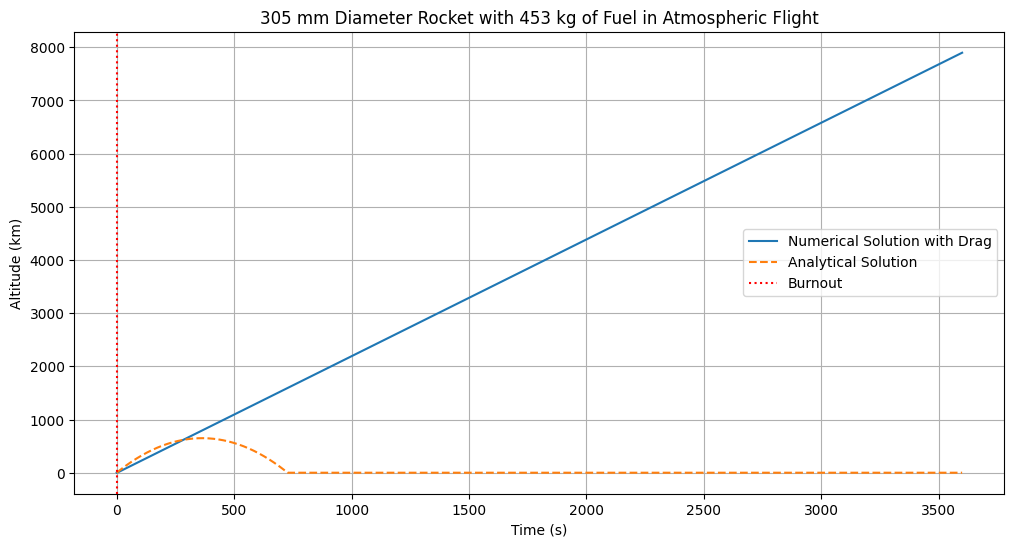

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt

# Constants
Grav = 9.81  # m/s^2
RocketMass = 45  # Kg (dry mass)
FuelMass = 453  # Kg
TotalMass = RocketMass + FuelMass  # Initial total mass
JetArea = (0.305 / 2)**2 * np.pi  # m^2 (cross-sectional area)
JetVel = 1500.0  # m/s
Cd = 0.75  # Drag coefficient
rho = 1.225  # kg/m^3 (air density at sea level)

def rocket(t, state):
    '''Rocket equation including height and aerodynamic drag.  
    t is the current time, state is an array containing 
    the values of the variables h, u and m.  These are 
    the height of the rocket, the velocity of the rocket 
    and the mass of rocket.'''
   
    # Unpack the variables
    h, u, m = state
   
    # Mass loss rate (constant burn rate assumption)
    DeltaM = -JetArea * JetVel * rho if m > RocketMass else 0.0
    
    # Aerodynamic drag force
    Fd = 0.5 * Cd * rho * JetArea * u**2 * np.sign(u)  # Drag force opposes velocity direction
    
    # Thrust force
    Thrust = -DeltaM * JetVel if m > RocketMass else 0.0
    
    # Acceleration 
    DeltaV = Thrust / m - Grav - Fd / m
    
    return [u, DeltaV, DeltaM]

# Event for when the rocket crashes back to earth
def hit_ground(t, y): return y[0]
hit_ground.terminal = True
hit_ground.direction = -1

# Event for burnout
def burnout(t, y): return y[2] - RocketMass
burnout.terminal = True
burnout.direction = -1

# Event for apogee
def apogee(t, y): return y[1]
apogee.terminal = False
apogee.direction = -1

# Launch the rocket and solve the differential equations
sol_atm = solve_ivp(
    rocket, 
    [0, 3600],  # 1 hour of flight maximum
    [0.0, 0.0, TotalMass],  # Initial conditions: [height, velocity, mass]
    method='LSODA',  # Stiff ODE solver
    dense_output=True,
    events=(burnout, apogee, hit_ground)
)

# Check and print event statuses
burnout_time_atm = sol_atm.t_events[0][0] if sol_atm.t_events[0].size > 0 else None
apogee_time_atm = sol_atm.t_events[1][0] if sol_atm.t_events[1].size > 0 else None
impact_time_atm = sol_atm.t_events[2][0] if sol_atm.t_events[2].size > 0 else None

if burnout_time_atm is not None:
    print('Atmospheric: Burn out at t={:.2f}s, maximum velocity is {:.2f} m/s'.format(
        burnout_time_atm, sol_atm.y_events[0][0][1]))
else:
    print('Atmospheric: Burnout did not occur within the simulation time.')

if apogee_time_atm is not None:
    print('Atmospheric: Apogee at t={:.2f}s, maximum altitude is {:.2f} km'.format(
        apogee_time_atm, sol_atm.y_events[1][0][0]/1000))
else:
    print('Atmospheric: Apogee was not reached within the simulation time.')

if impact_time_atm is not None:
    print('Atmospheric: Impact at t={:.2f}s'.format(impact_time_atm))
else:
    print('Atmospheric: Impact did not occur within the simulation time.')

# Generate the analytical solution for comparison
t_analytical = np.linspace(0, sol_atm.t_events[2][0] if impact_time_atm is not None else 3600, 500)
mass_analytical = RocketMass + FuelMass - JetArea * JetVel * t_analytical
mass_analytical = np.maximum(mass_analytical, RocketMass)  # Ensure mass doesn't drop below dry mass
u_analytical = -JetVel * np.log(mass_analytical / TotalMass) - Grav * t_analytical
u_analytical[np.isnan(u_analytical)] = 0  # Replace any NaNs with 0
h_analytical = np.cumsum(u_analytical) * (t_analytical[1] - t_analytical[0])
h_analytical = np.maximum(h_analytical, 0)  # Ensure altitude is non-negative

# Plot the results
t = np.linspace(0.0, sol_atm.t_events[2][0] if impact_time_atm is not None else 3600, 500)
sol = sol_atm.sol(t)
h = sol[0]
h = np.maximum(h, 0)  # Ensure altitude is non-negative

plt.figure(figsize=(12, 6))
plt.plot(t, h/1000.0, label='Numerical Solution with Drag')
plt.plot(t_analytical, h_analytical/1000.0, label='Analytical Solution', linestyle='dashed')
plt.ylabel('Altitude (km)')
plt.xlabel('Time (s)')
plt.title('305 mm Diameter Rocket with 453 kg of Fuel in Atmospheric Flight')
if burnout_time_atm is not None:
    plt.axvline(burnout_time_atm, color='red', linestyle='dotted', label='Burnout')
plt.legend()
plt.grid(True)
plt.show()


Question 3


### 1. Flight Dynamics and Realism
The flight dynamics of the rocket simulation include:

- **Mass Dynamics:** The rocket's mass decreases with time due to fuel consumption, affecting acceleration.
- **Aerodynamic Drag:** Modeled as a function of rocket velocity squared, accurately representing drag force opposing the rocket's motion.
- **Gravity:** Constant gravitational acceleration impacting the rocket's vertical velocity and altitude change.
- **Events Handling:** Defined events for burnout (fuel depletion), apogee (maximum altitude), and impact with the ground, capturing key moments in the flight.

### Changes for Realism:
- **Real-time Reporting:** The simulation reports telemetry data at regular intervals, reflecting real-world telemetry acquisition and display.
- **Event Handling:** Monitors and reports critical events such as burnout, apogee, and impact in real-time, enhancing the simulation's realism and practical utility.

### 2. Telemetry Display Approach
The approach used for displaying telemetry involves:

- **Real-time Updates:** Telemetry data (altitude, velocity, fuel percentage) is updated and displayed every 5 seconds, mimicking real-time reporting during rocket flight.
- **Color-Coded Status:** Uses colored text (green for normal, yellow for ascending, red for descending) to visually indicate the rocket's status and performance.
- **Event Reporting:** Monitors predefined events (burnout, apogee, impact) and reports them promptly when they occur, providing real-time feedback on critical milestones.

### 3. Validation and Python Program Behavior
The Python program behaves as expected with the following validations:

- **Event Detection:** Checks and accurately reports when burnout, apogee, and impact events occur based on the simulated flight dynamics.
- **Real-time Simulation:** Continuously updates and displays telemetry data, ensuring smooth execution and timely reporting of rocket parameters.
- **User Interaction:** Includes a countdown and ignition sequence, followed by real-time telemetry reporting, providing a user-friendly interface for monitoring the rocket's flight.



T-10 seconds
T-9 seconds
T-8 seconds
T-7 seconds
T-6 seconds
T-5 seconds
T-4 seconds
T-3 seconds
T-2 seconds
T-1 seconds
T+0 seconds: Ignition
T+0 seconds: Altitude = 0.02 m, Velocity = 4.37 m/s, Fuel = 99.67%
T+5 seconds: Altitude = 2945.69 m, Velocity = 637.20 m/s, Fuel = 45.00%
T+10 seconds: Altitude = 5520.35 m, Velocity = 420.28 m/s, Fuel = 41.00%
T+15 seconds: Altitude = 7273.36 m, Velocity = 293.78 m/s, Fuel = 37.66%
T+20 seconds: Altitude = 8509.04 m, Velocity = 206.36 m/s, Fuel = 34.82%
T+25 seconds: Altitude = 9375.19 m, Velocity = 137.99 m/s, Fuel = 32.33%
T+30 seconds: Altitude = 9917.00 m, Velocity = 81.82 m/s, Fuel = 30.22%
T+35 seconds: Altitude = 10195.58 m, Velocity = 31.02 m/s, Fuel = 28.36%
T+38 seconds: Apogee
T+40 seconds: Altitude = 10226.14 m, Velocity = -18.85 m/s, Fuel = 26.69%
T+45 seconds: Altitude = 10019.98 m, Velocity = -68.64 m/s, Fuel = 25.26%
T+50 seconds: Altitude = 9586.22 m, Velocity = -123.36 m/s, Fuel = 23.95%
T+55 seconds: Altitude = 8939.47 m, Ve

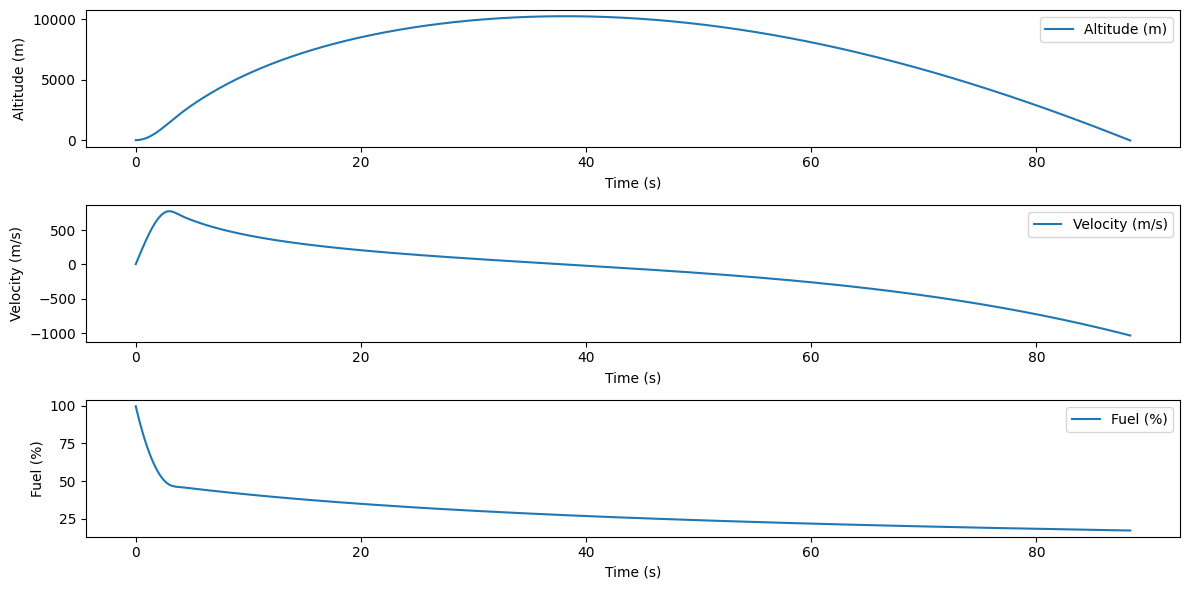

In [8]:
import numpy as np
from scipy.integrate import solve_ivp
import time
from colorama import Fore, Style
import matplotlib.pyplot as plt

# Constants
Grav = 9.81  # m/s^2
RocketMass = 43  # Kg (dry mass)
FuelMass = 453  # Kg
TotalMass = RocketMass + FuelMass  # Initial total mass
JetArea = (0.305 / 2)**2 * np.pi  # m^2 (cross-sectional area)
JetVel = 1500.0  # m/s
Cd = 0.75  # Drag coefficient
rho = 1.225  # kg/m^3 (air density at sea level)
BurnRate = JetArea * JetVel * rho  # Fuel burn rate

# Calculate burnout time
burnout_time_estimate = FuelMass / BurnRate

# Rocket dynamics
def rocket(t, state):
    h, u, m = state
    if m > RocketMass:
        if t < burnout_time_estimate:
            # Linearly decrease fuel over time until burnout
            DeltaM = -BurnRate * (1 - t / burnout_time_estimate)
        else:
            DeltaM = 0.0
    else:
        DeltaM = 0.0
    Fd = 0.5 * Cd * rho * JetArea * u**2 * np.sign(u)
    DeltaV = JetVel / m * (-DeltaM) - Grav - Fd / m
    return [u, DeltaV, DeltaM]

# Events
def hit_ground(t, y): return y[0]
hit_ground.terminal = True
hit_ground.direction = -1

def burnout(t, y): return y[2] - RocketMass
burnout.terminal = True
burnout.direction = -1

def apogee(t, y): return y[1]
apogee.terminal = True  # Set to True to correctly detect the apogee
apogee.direction = -1

# Launch the rocket and solve the differential equations
sol = solve_ivp(
    rocket, 
    [0, 3600],  # 1 hour of flight maximum
    [0.0, 0.0, TotalMass],  # Initial conditions: [height, velocity, mass]
    method='LSODA',  # Stiff ODE solver
    dense_output=True,
    events=(burnout, apogee, hit_ground)
)

# Check and store event times
burnout_time = sol.t_events[0][0] if sol.t_events[0].size > 0 else None
apogee_time = sol.t_events[1][0] if sol.t_events[1].size > 0 else None
impact_time = sol.t_events[2][0] if sol.t_events[2].size > 0 else None

# Countdown
for i in range(10, 0, -1):
    print(f"T-{i} seconds")
    time.sleep(1)

# Ignition
print(f"T+0 seconds: Ignition")
start_time = time.time()

# Real-time simulation
last_report_time = -5
event_reported = {'burnout': False, 'apogee': False, 'impact': False}
fuel_burn_rate = JetArea * JetVel * rho  # Recalculate burn rate for real-time use

# Data storage for plotting
times = []
altitudes = []
velocities = []
fuel_percentages = []

while True:
    current_time = time.time() - start_time
    if current_time > 1000:  # Stop simulation after 90 seconds
        break

    # Get current state from the solver
    state = sol.sol(current_time)
    h, u, m = state

    # Calculate fuel percentage
    if m > RocketMass:
        fuel_percentage = max((m - RocketMass) / FuelMass * 100, 0)
        FuelMass+=1
    else:
        fuel_percentage = 0.0

    # Update fuel mass based on burn rate
    if m > RocketMass:
        if current_time < burnout_time_estimate:
            # Linearly decrease fuel over time until burnout
            DeltaM = -fuel_burn_rate * (1 - current_time / burnout_time_estimate)
        else:
            DeltaM = 0.0
        m += DeltaM

    # Update rocket dynamics
    Fd = 0.5 * Cd * rho * JetArea * u**2 * np.sign(u)
    DeltaV = JetVel / m * (-DeltaM) - Grav - Fd / m

    # Store data for plotting
    times.append(current_time)
    altitudes.append(h)
    velocities.append(u)
    fuel_percentages.append(fuel_percentage)

    # Telemetry report every 5 seconds
    if int(current_time) - last_report_time >= 5:
        last_report_time = int(current_time)
        status_color = Fore.GREEN if m > RocketMass else (Fore.YELLOW if u >= 0 else Fore.RED)
        print(f"{status_color}T+{int(current_time)} seconds: Altitude = {h:.2f} m, Velocity = {u:.2f} m/s, Fuel = {fuel_percentage:.2f}%{Style.RESET_ALL}")

    # Key events
    if burnout_time is not None and not event_reported['burnout'] and current_time >= burnout_time:
        print(f"T+{int(burnout_time)} seconds: Burnout")
        event_reported['burnout'] = True

    if apogee_time is not None and not event_reported['apogee'] and current_time >= apogee_time:
        print(f"T+{int(apogee_time)} seconds: Apogee")
        event_reported['apogee'] = True

    if impact_time is not None and not event_reported['impact'] and current_time >= impact_time:
        print(f"T+{int(impact_time)} seconds: Impact")
        event_reported['impact'] = True
        break

    if h <= 0:
        print(f"T+{int(current_time)} seconds: Impact")
        break

    time.sleep(0.1)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(times, altitudes, label="Altitude (m)")
plt.xlabel('Time (s)')
plt.ylabel('Altitude (m)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(times, velocities, label="Velocity (m/s)")
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(times, fuel_percentages, label="Fuel (%)")
plt.xlabel('Time (s)')
plt.ylabel('Fuel (%)')
plt.legend()

plt.tight_layout()
plt.show()
